In [2]:
from cpa_utils import *

# Elisabeth-b4 - Filter block

In [3]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"
locations_path = "correlation_locations_b4_two_last_rounds.pic"

In [5]:
seeds, traces, real_keys, correlation_locations = load_data(traces_path, key_path, locations_path)

## Attacking the additions between elements of the block before the S-boxes

In [4]:
def hypothesis_b4_rws_preliminary_additions(iv: str, key: List[int], round_idx: int, block_indices: Tuple[int, int]) -> int:
    block_idx_1, block_idx_2 = block_indices
    if block_idx_1 != block_idx_2 - 1 or block_idx_2 % 2 != 1 or block_idx_2 >= BLOCK_WIDTH_B4:
        raise ValueError
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    return HD[block[block_idx_2] + block[block_idx_1]][block[block_idx_2]]

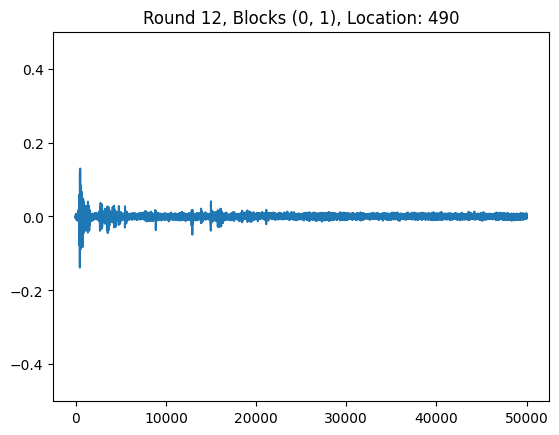

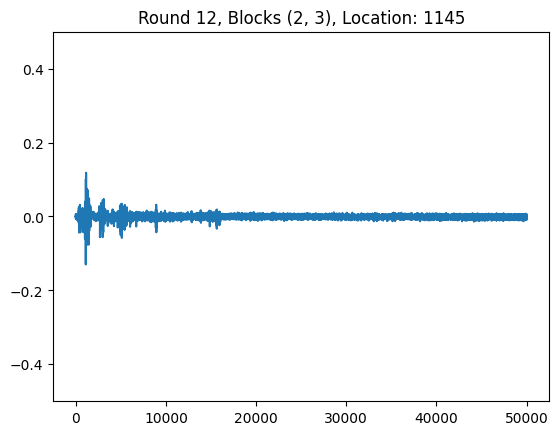

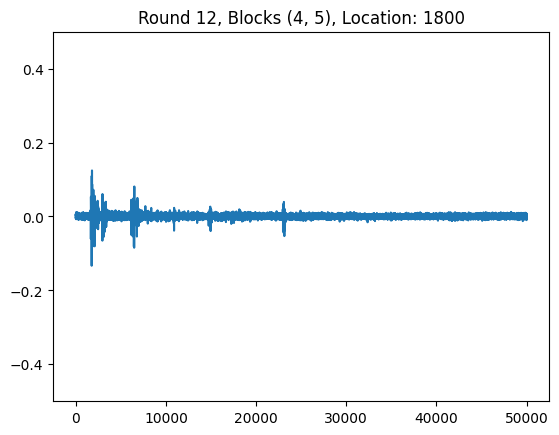

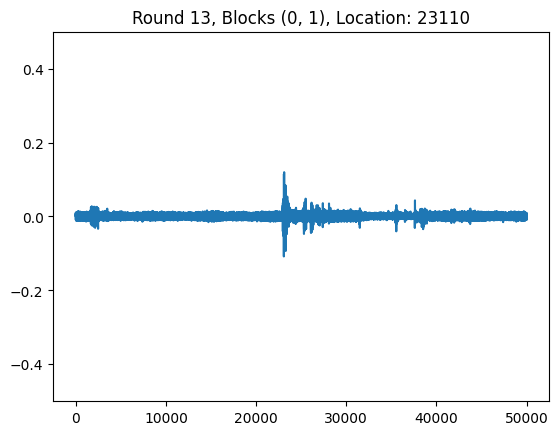

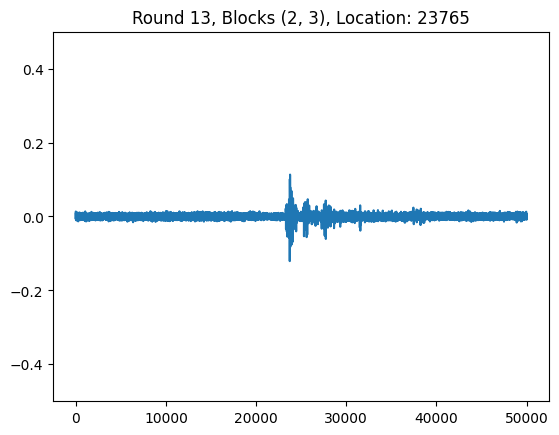

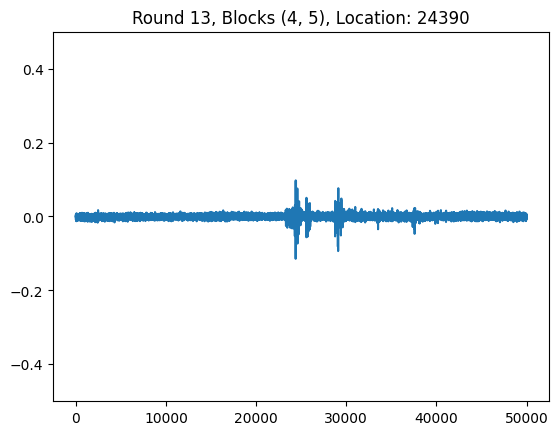

In [5]:
for round_idx in range(12, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    for block_idx_1, block_idx_2 in zip(range(0, BLOCK_WIDTH_B4, 2), range(1, BLOCK_WIDTH_B4, 2)):
        hyps = np.array([hypothesis_b4_rws_preliminary_additions(iv, key, round_idx, (block_idx_1, block_idx_2)) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        plt.plot(corr)
        plt.ylim([-0.5, 0.5])
        plt.title(f"Round {round_idx}, Blocks {(block_idx_1, block_idx_2)}, Location: {loc}")
        plt.show()

Neat !

## Attacking [i][x[i]] (and just x[i])

In [30]:
def hypothesis_b4_rws_i_x_i(iv: str, key: List[int], round_idx: int, block_idx: int) -> int:
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    return HW[block[block_idx] + (block_idx << 4)]

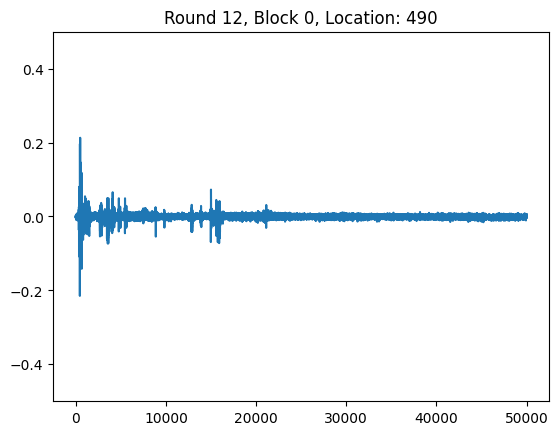

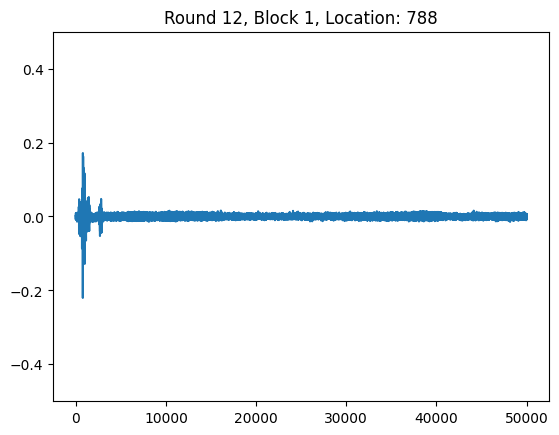

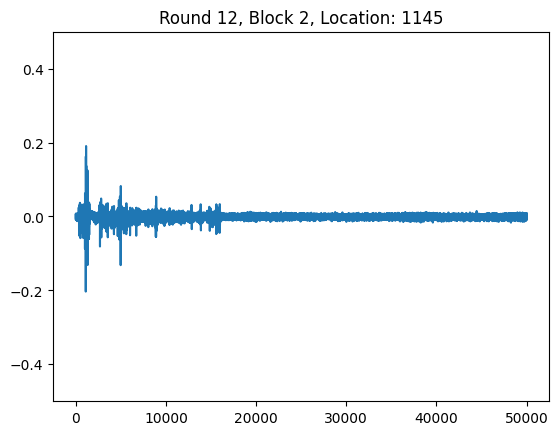

KeyboardInterrupt: 

In [32]:
for round_idx in range(12, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    for block_idx in range(0, BLOCK_WIDTH_B4 - 1):
        hyps = np.array([hypothesis_b4_rws_i_x_i(iv, key, round_idx, block_idx) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        plt.plot(corr)
        plt.ylim([-0.5, 0.5])
        plt.title(f"Round {round_idx}, Block {block_idx}, Location: {loc}")
        plt.show()

In [6]:
def hypothesis_b4_rws_x_i(iv: str, key: List[int], round_idx: int, block_idx: int) -> int:
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    return HW[block[block_idx]]

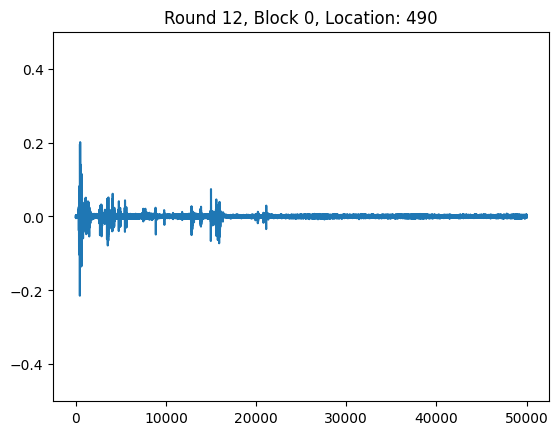

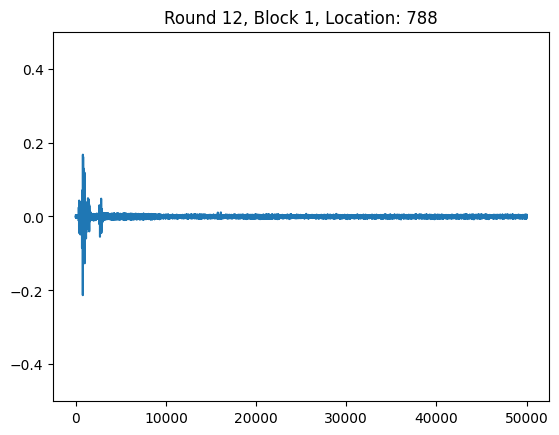

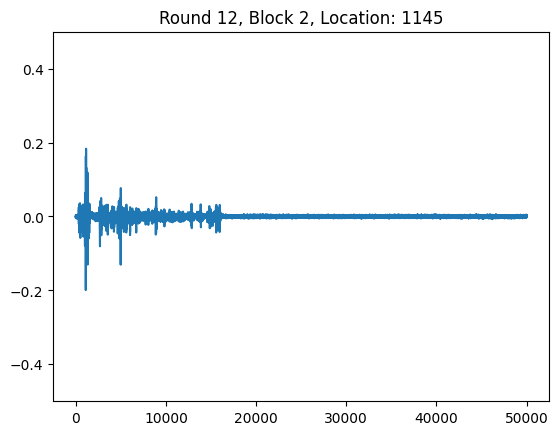

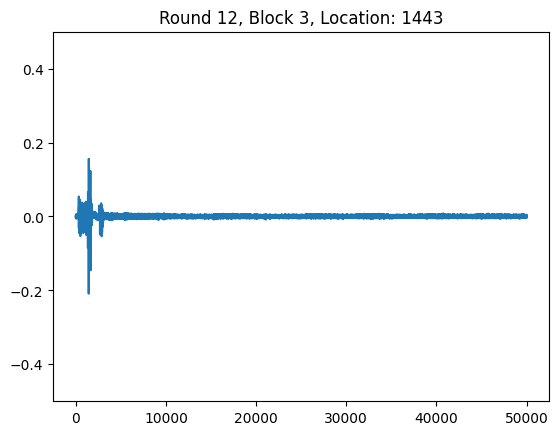

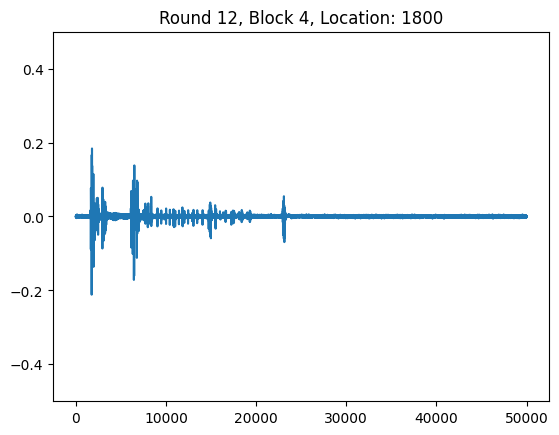

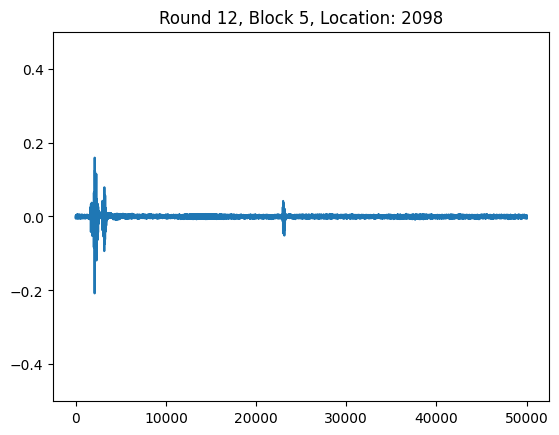

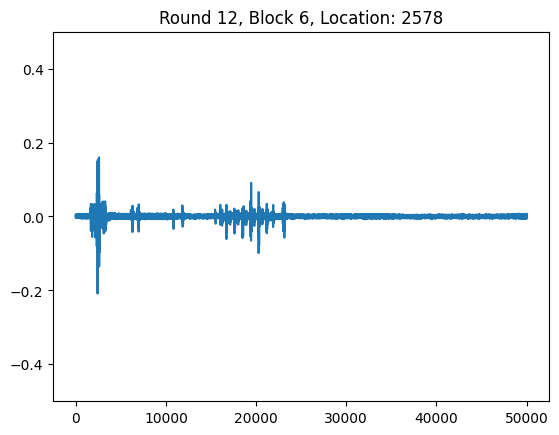

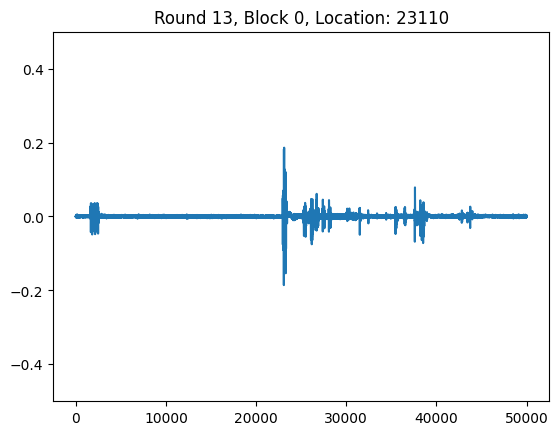

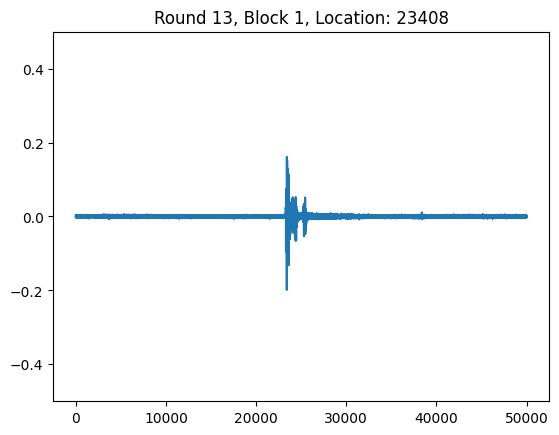

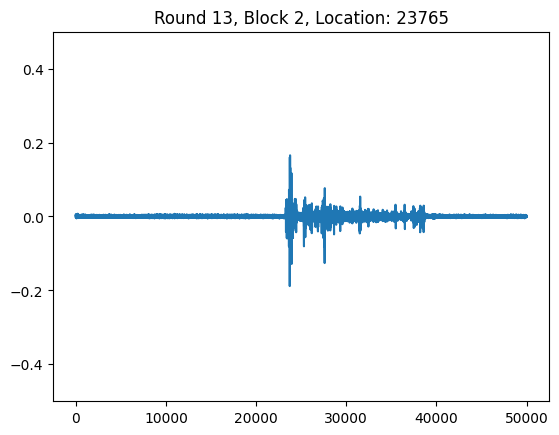

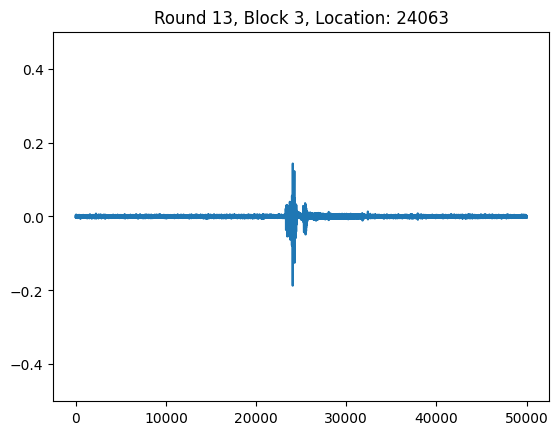

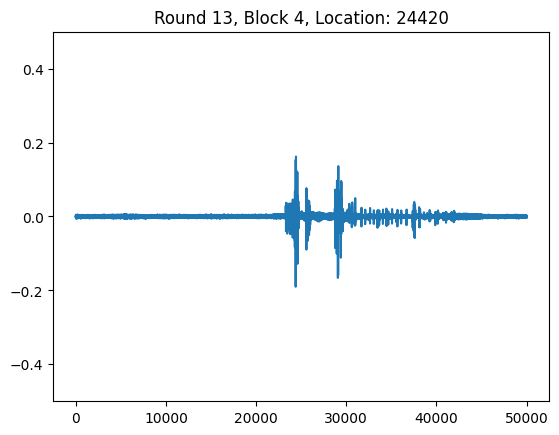

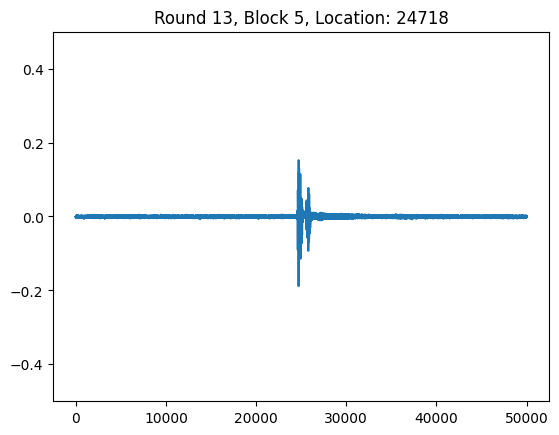

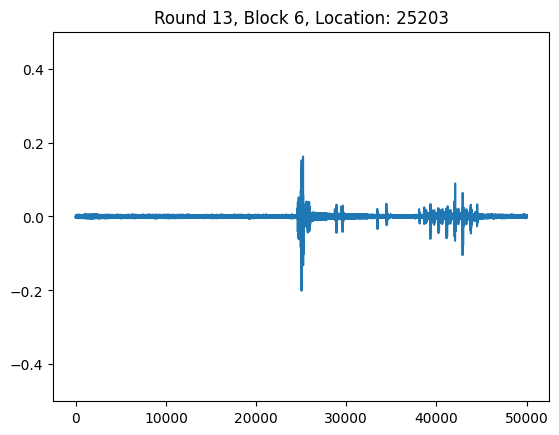

In [7]:
correlation_locations = [[[0] * 10] * BLOCK_WIDTH_B4] * (KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2)
for round_idx in range(len(correlation_locations), KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    corr_round = []
    for block_idx in range(0, BLOCK_WIDTH_B4):
        hyps = np.array([hypothesis_b4_rws_x_i(iv, key, round_idx, block_idx) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        corr_round.append(list(range(loc - 5, loc + 5)))
        plt.plot(corr)
        plt.ylim([-0.5, 0.5])
        plt.title(f"Round {round_idx}, Block {block_idx}, Location: {loc}")
        plt.show()
    correlation_locations.append(corr_round)
correlation_locations = np.array(correlation_locations)

with open("correlation_locations_b4_two_last_rounds_hw_x_i.pic", "wb") as w:
    pic.dump(correlation_locations, w)



The same: my guess is that adding a constant to the Hamming weight does not change anything, all hypotheses are simply shifted by 1 (or more, depending on the block index) so correlations are the same.

Other than that, it looks even more promising that the previous one !

## Attacking S-boxes difference

In [35]:
def hypothesis_b4_rws_sbox_diff(iv: str, key: List[int], round_idx: int, block_idx: int) -> int:
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    if block_idx % 2 == 0:
        sbox_curr = s_boxes_b4[block_idx][block[block_idx]]
        sbox_prev = s_boxes_b4[block_idx - 1][(block[block_idx - 1] + block[block_idx - 2]) % 16]
    else:
        sbox_curr = s_boxes_b4[block_idx][(block[block_idx] + block[block_idx - 1]) % 16]
        sbox_prev = s_boxes_b4[block_idx - 1][block[block_idx - 1]]
    return HD[sbox_prev][sbox_curr]

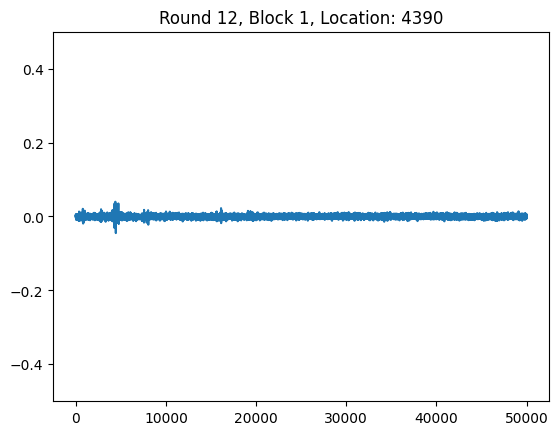

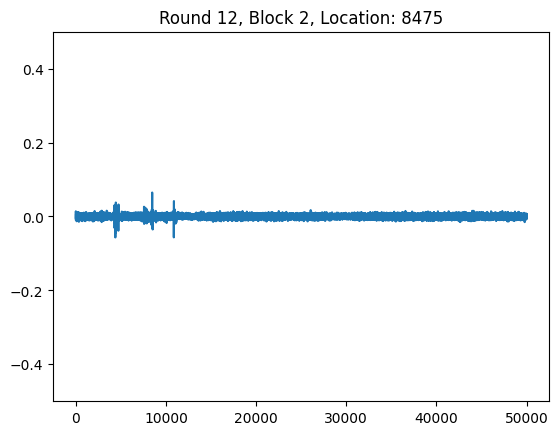

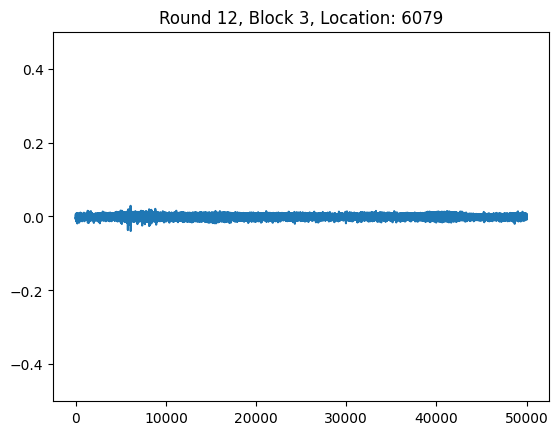

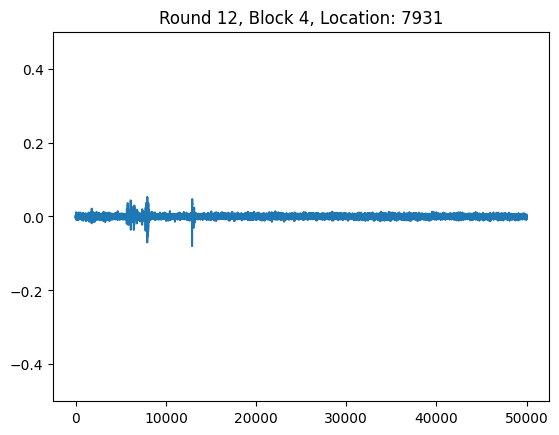

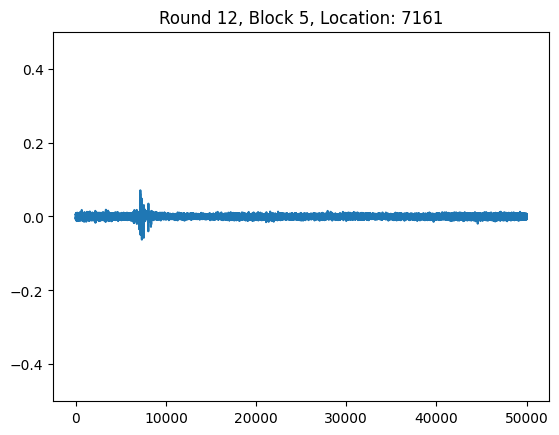

KeyboardInterrupt: 

In [36]:
for round_idx in range(12, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    for block_idx in range(1, BLOCK_WIDTH_B4 - 1):
        hyps = np.array([hypothesis_b4_rws_sbox_diff(iv, key, round_idx, block_idx) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        plt.plot(corr)
        plt.ylim([-0.5, 0.5])
        plt.title(f"Round {round_idx}, Block {block_idx}, Location: {loc}")
        plt.show()

Meh

## Attacking modulo

In [37]:
def hypothesis_b4_rws_modulo(iv: str, key: List[int], round_idx: int, block_indices: Tuple[int, int]) -> int:
    block_idx_1, block_idx_2 = block_indices
    if block_idx_1 != block_idx_2 - 1 or block_idx_2 % 2 != 1 or block_idx_2 >= BLOCK_WIDTH_B4:
        raise ValueError
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    return HD[block[block_idx_2] + block[block_idx_1]][(block[block_idx_2] + block[block_idx_1]) % 16]

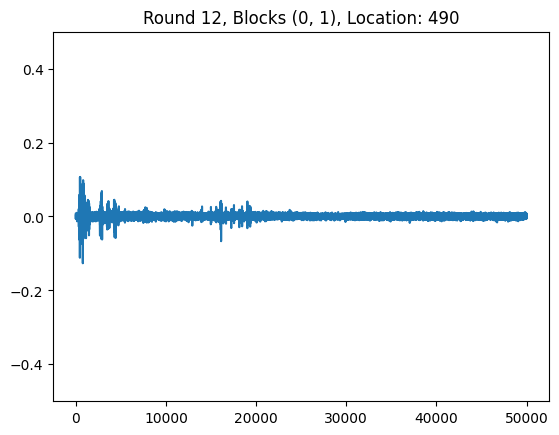

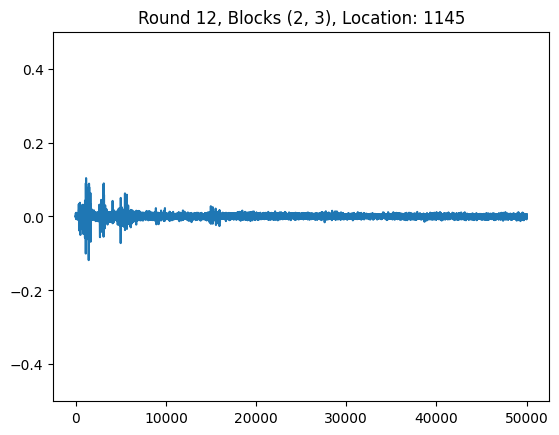

KeyboardInterrupt: 

In [38]:
for round_idx in range(12, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    for block_idx_1, block_idx_2 in zip(range(0, BLOCK_WIDTH_B4, 2), range(1, BLOCK_WIDTH_B4, 2)):
        hyps = np.array([hypothesis_b4_rws_modulo(iv, key, round_idx, (block_idx_1, block_idx_2)) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        plt.plot(corr)
        plt.ylim([-0.5, 0.5])
        plt.title(f"Round {round_idx}, Blocks {(block_idx_1, block_idx_2)}, Location: {loc}")
        plt.show()

Not too bad.

## Attacking register reuse

In [39]:
def hypothesis_b4_rws_r3_use(iv: str, key: List[int], round_idx: int, block_indices: Tuple[int, int]) -> int:
    block_idx_1, block_idx_2 = block_indices
    if block_idx_1 != block_idx_2 - 1 or block_idx_2 % 2 != 1 or block_idx_2 >= BLOCK_WIDTH_B4:
        raise ValueError
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    if block_idx_2 == 1 or block_idx_2 == 3:
        return HD[(block[block_idx_2] + block[block_idx_1]) % 16][block[block_idx_2 + 2]]
    elif block_idx_2 == 5:
        return HW[(block[block_idx_2] + block[block_idx_1]) % 16]
    else:
        raise ValueError

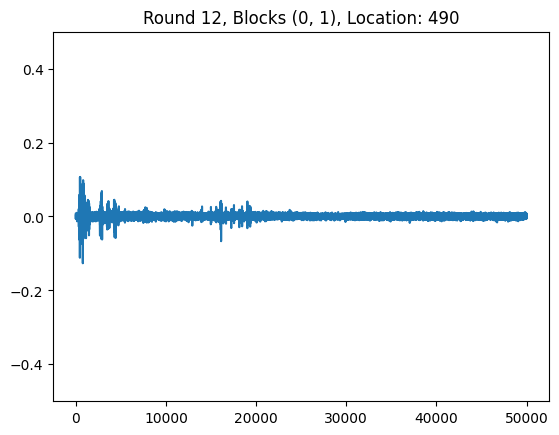

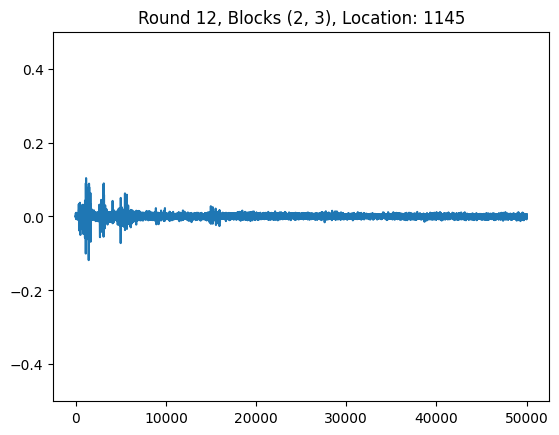

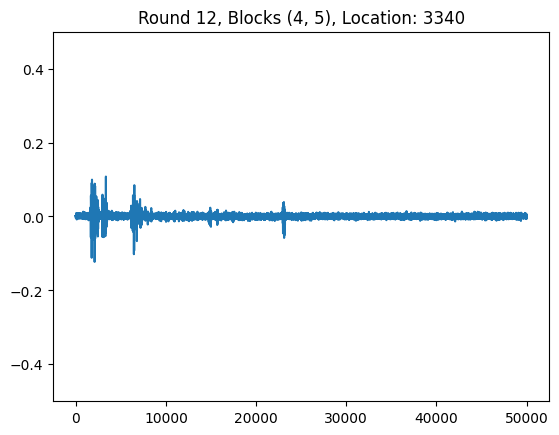

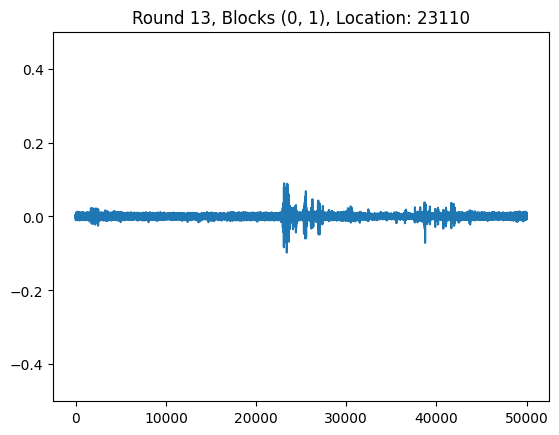

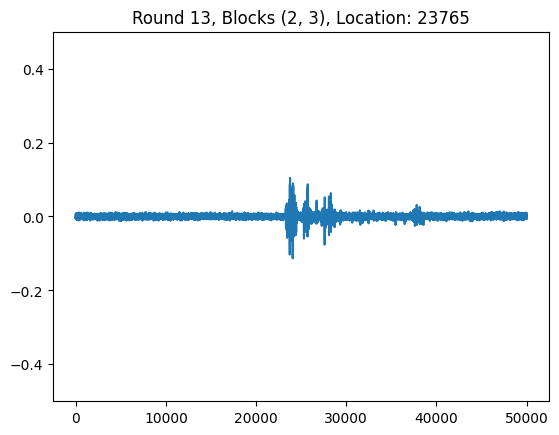

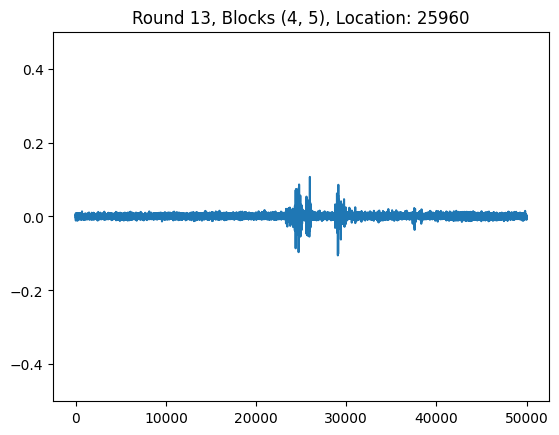

In [40]:
for round_idx in range(12, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    for block_idx_1, block_idx_2 in zip(range(0, BLOCK_WIDTH_B4, 2), range(1, BLOCK_WIDTH_B4, 2)):
        hyps = np.array([hypothesis_b4_rws_modulo(iv, key, round_idx, (block_idx_1, block_idx_2)) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        plt.plot(corr)
        plt.ylim([-0.5, 0.5])
        plt.title(f"Round {round_idx}, Blocks {(block_idx_1, block_idx_2)}, Location: {loc}")
        plt.show()

Not too bad either.

## For comparison, below are the plain s-boxes.

In [13]:
def a(iv: str, key: List[int], round_idx: int, block_idx: int) -> int:
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    if block_idx % 2 == 0:
        sbox_out = s_boxes_b4[block_idx][block[block_idx]]
    else:
        sbox_out = s_boxes_b4[block_idx][(block[block_idx] + block[block_idx - 1]) % 16]
    return HW[sbox_out]

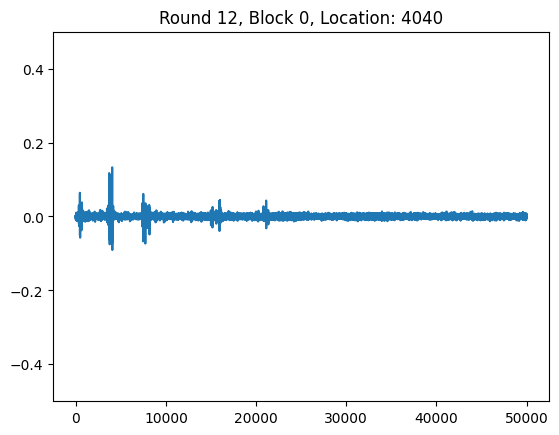

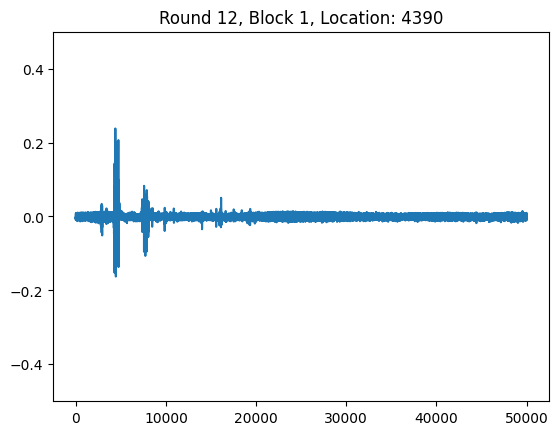

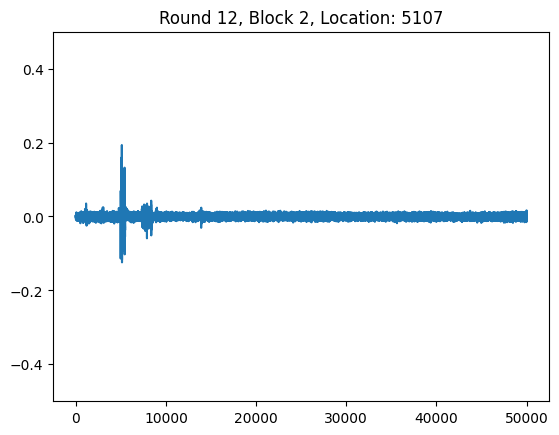

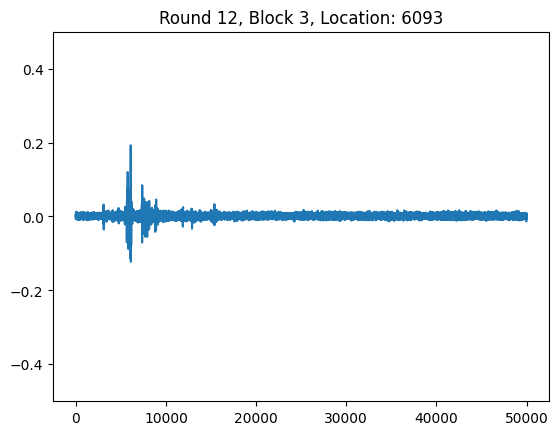

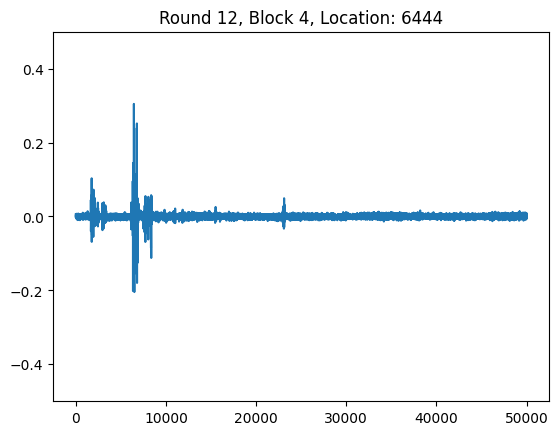

KeyboardInterrupt: 

In [14]:
for round_idx in range(12, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    for block_idx in range(BLOCK_WIDTH_B4 - 1):
        hyps = np.array([a(iv, key, round_idx, block_idx) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        plt.plot(corr)
        plt.ylim([-0.5, 0.5])
        plt.title(f"Round {round_idx}, Block {block_idx}, Location: {loc}")
        plt.show()